# Phenotype file creation for:
1. Hearing aids (f.3393)
2. Hearing difficulty/problems (f.2247)
3. Hearing difficulty/background noise (f.2257)
4. Combined phenotype (f2247 & f.2257)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

In the phenotypes folder important phenotypic files 

```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## Analysis plan

The phenotypes to be analyzed are the following:

1. Hearing aid user (f.3393)
"Do you use a hearing aid most of the time?"

2. Hearing difficulty/problems (f.2247)
"Do you have any difficulty with your hearing?"

3. Hearing difficulty/background noise (f.2257)
"Do you find it difficult to follow a conversation if there is background noise (such as TV, radio, children playing)?"

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The SRT trait needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836


In [ ]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()

## Load imputed data

In [2]:
#Set working directory
setwd('~/project/HI_UKBB/ukb42495_updatedJune2020')

In [3]:
# Clean workspace
rm(list=ls())

### Using only white british

In [4]:
df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')

### Using all whites

In [4]:
df.final.imp = read.csv('120120_UKBB_HI_expandedwhite_genotypeqc_excr.csv')

## Load exome data

In [2]:
setwd('/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment')
df.final.imp = read.csv(file = '010621_UKBB_HI_exomes_182221ind_excr.csv', header=TRUE)

In [3]:
head(df.final.imp)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.131229.0.0,f.131230.0.0,f.131231.0.0,f.131232.0.0,f.131233.0.0,f.131250.0.0,f.131251.0.0,f.131252.0.0,f.131253.0.0,exclude
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE


## Data summary and recode

In [4]:
dim(df.final.imp) #354347 only brits 1082 vars

[1] 182221   2262

In [5]:
compare_sex <- df.final.imp %>% 
      mutate(sex_final = case_when(
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Female" ~ "0",
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Male" ~ "1",
       TRUE ~ '3')) %>%
    select(IID, f.31.0.0, f.22001.0.0, sex_final) %>%
    filter(sex_final==3)
head(compare_sex, 10)
dim(compare_sex) #Number of individuals inconsistent for self-reported and genetic sex

,IID,f.31.0.0,f.22001.0.0,sex_final
,<int>,<fct>,<fct>,<chr>
1,1045692,Female,NA,3
2,1048098,Male,NA,3
3,1068847,Male,Female,3
4,1096848,Male,NA,3
5,1101132,Male,Female,3
6,1121872,Female,NA,3
7,1161768,Male,Female,3
8,1184630,Female,NA,3
9,1236324,Male,Female,3


[1] 215   4

## Remove sex inconsistent individuals

In [6]:
remove_sex <- compare_sex %>% 
    select(IID)
head(remove_sex)
dim(remove_sex)

,IID
,<int>
1,1045692
2,1048098
3,1068847
4,1096848
5,1101132
6,1121872


[1] 215   1

In [7]:
df.final.imp <-  df.final.imp[!df.final.imp$IID %in% remove_sex$IID,]
dim(df.final.imp)

[1] 182006   2262

In [8]:
df.final.imp$sex <- revalue(df.final.imp$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df.final.imp$sex)
dim(df.final.imp)


     1      0 
100570  81436 

[1] 182006   2263

In [9]:
length(which(is.na(df.final.imp$sex)))

[1] 0

# f.3393 Hearing aid: filter out inconsistent cases

In [10]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.3393.0.0","f.3393.1.0","f.3393.2.0","f.3393.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer



f.3393.0.0_recode summary:
     0      1 
113015   4932 

f.3393.1.0_recode summary:
   0    1 
8946  479 

f.3393.2.0_recode summary:
    0     1 
22220  1744 

f.3393.3.0_recode summary:
  0   1 
865  66 



In [11]:
dim(df.final.imp)

[1] 182006   2267

## f. 3393 Get patterns for possible answers

In [12]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "001"  "0010" "0011" "01"  
[11] "010"  "011"  "0111" "1"    "10"   "100"  "101"  "11"   "110"  "1100"
[21] "111"  "1111"

In [18]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001    001   0010   0011     01    010 
 53669 103534  15345   2959    104      2    149      2      1    981     19 
   011   0111      1     10    100    101     11    110   1100    111   1111 
   126      3   4482     39      6     14    464      2      1    100      4 

## f.3393 Get all the consistent cases

In [19]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(all_no,all_yes),"visit"])


     0     00    000   0000      1     11    111   1111 
103534  15345   2959    104   4482    464    100      4 

In [20]:
consistent_1<-c(all_no,all_yes)
yes_no<-all_pattern[which(grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010  011 0111   10  100  101  110 1100 
   2  149    2    1  981   19  126    3   39    6   14    2    1 

In [21]:
might_inconsistent<-c(yes_no)

## f.3393 Remove inconsistent cases

In [22]:
# get all the inconsistent cases:
exceptions<-c("0001","001","0011","01","011","0111")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 53669 NAs, removed

In [23]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 83 inconsistent cases, removed

In [24]:
# removed those NAs and inconsistent cases: 
IID_hearing_aid<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  select(IID)

dim(IID_hearing_aid)

[1] 128254      1

In [25]:
IID_hearing_aid<-IID_hearing_aid[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_aid)," individuals left")

After removing all the NAs and inconsistent cases, there are 128254  individuals left

In [26]:
# get the dataset after cleansing: 
df.hearing.aid<-df.final.imp %>%
  filter(IID%in%IID_hearing_aid)

dim(df.hearing.aid)

[1] 128254   2267

## f.3393 Step 1: classify cases and controls

In [27]:
hearing_aid <- df.hearing.aid %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode)
head(hearing_aid)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA


## Hearing aid f.3393

In [28]:
data_sub <- select(hearing_aid,starts_with("f.3393"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_aid$cases<-apply(data_sub, 1, f)
head(hearing_aid,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
7,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE
8,1000304,1000304,Female,56,NA,NA,NA,0,NA,NA,NA,FALSE
9,1000331,1000331,Female,53,NA,NA,NA,0,NA,NA,NA,FALSE


In [29]:
hearing_aid_cases <- hearing_aid %>% 
  filter(cases == TRUE)
head(hearing_aid_cases)
cat(dim(hearing_aid_cases)[1], "individuals are cases for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1001384,1001384,Female,61,NA,NA,NA,1,NA,NA,NA,TRUE
2,1002548,1002548,Male,62,NA,NA,NA,1,NA,NA,NA,TRUE
3,1002888,1002888,Male,68,NA,NA,NA,1,NA,NA,NA,TRUE
4,1002944,1002944,Male,65,NA,NA,NA,1,NA,NA,NA,TRUE
5,1003258,1003258,Male,69,74,NA,NA,0,1,NA,NA,TRUE
6,1004843,1004843,Male,64,NA,NA,NA,1,NA,NA,NA,TRUE


6312 individuals are cases for f.3393

In [30]:
hearing_aid_controls <- hearing_aid %>% 
  filter(cases == FALSE)
head(hearing_aid_controls)
cat(dim(hearing_aid_controls)[1], "individuals are controls for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE


121942 individuals are controls for f.3393

In [208]:
dim(hearing_aid)[1]-6512 -130796

[1] 0

## f.3393 Recode cases=1 and controls=0

In [31]:
hearing_aid$hearing_aid_cat <- as.integer(as.logical(hearing_aid$cases))
head(hearing_aid, 10)
# Get the number of NAs
#length(which(is.na(hearing_all$hearing_aid_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE,0
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
7,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0
8,1000304,1000304,Female,56,NA,NA,NA,0,NA,NA,NA,FALSE,0
9,1000331,1000331,Female,53,NA,NA,NA,0,NA,NA,NA,FALSE,0


In [32]:
dim(hearing_aid)

[1] 128254     13

## Step 2: get the ages for hearing aids (f.3393)

In [33]:
# Get the subset data of cases
aid_age_cases = hearing_aid %>% 
  filter(hearing_aid_cat=="1")  %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_cases,12)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA
2,1002548,1,NA,NA,NA,62,NA,NA,NA
3,1002888,1,NA,NA,NA,68,NA,NA,NA
4,1002944,1,NA,NA,NA,65,NA,NA,NA
5,1003258,0,1,NA,NA,69,74,NA,NA
6,1004843,1,NA,NA,NA,64,NA,NA,NA
7,1006454,1,NA,NA,NA,64,NA,NA,NA
8,1006513,0,NA,1,NA,54,NA,59,NA
9,1007725,1,NA,NA,NA,69,NA,NA,NA


In [34]:
# Get the # of column where first replied Yes:
aid_age_cases$visit_idx = apply(aid_age_cases, 1, function(x) unlist(which(x == '1')))
head(aid_age_cases)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2
5,1003258,0,1,NA,NA,69,74,NA,NA,3
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2


In [35]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_cases) == 'f.21003.0.0') - which(colnames(aid_age_cases) == 'f.3393.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
aid_age_cases$age_final_aid = apply(aid_age_cases, 1, f)

# Show first 6 rows
head(aid_age_cases)
summary(aid_age_cases$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2,65
5,1003258,0,1,NA,NA,69,74,NA,NA,3,74
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2,64


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   61.00   65.00   63.85   68.00   82.00 

In [36]:
### Extract age for Control (3393)
aid_age_control <- hearing_aid %>% 
  filter(hearing_aid_cat == "0") %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_control)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA
2,1000035,0,NA,NA,NA,63,NA,NA,NA
3,1000078,NA,0,0,NA,52,57,60,NA
4,1000081,0,NA,NA,NA,67,NA,NA,NA
5,1000198,0,NA,NA,NA,41,NA,NA,NA
6,1000236,0,NA,0,NA,61,NA,70,NA


In [37]:
# Get the # of column where last replied No:
aid_age_control$visit_idx = apply(aid_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_control) == 'f.21003.0.0') - which(colnames(aid_age_control) == 'f.3393.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
aid_age_control$age_final_aid = apply(aid_age_control, 1, f)

# Show first 6 rows
head(aid_age_control)
summary(aid_age_control$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
3,1000078,NA,0,0,NA,52,57,60,NA,"3, 4",60
4,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
5,1000198,0,NA,NA,NA,41,NA,NA,NA,2,41
6,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   52.00   60.00   58.41   65.00   82.00 

In [38]:
# Merge age_cases and age_controls
hearing_aid_age <- rbind(aid_age_cases, aid_age_control) 
dim(hearing_aid_age)
head(hearing_aid_age)

[1] 128254     11

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2,65
5,1003258,0,1,NA,NA,69,74,NA,NA,3,74
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2,64


In [39]:
hearing_cat_age = merge(x = hearing_aid ,y = hearing_aid_age [,c("IID","age_final_aid")],by="IID", all.x=TRUE)
head(hearing_cat_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat,age_final_aid
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0,47
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE,0,41
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0,70


In [40]:
#Merge with complete database keep the all the rows from original db
df_3393 = merge(x = df.final.imp, y = hearing_cat_age [,c("IID","hearing_aid_cat","age_final_aid")],by="IID", all.x=TRUE)
dim(df_3393)
head(df_3393)

[1] 182006   2269

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.131252.0.0,f.131253.0.0,exclude,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,FALSE,1,0,NA,NA,NA,0,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,FALSE,0,0,NA,NA,NA,0,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,FALSE,1,NA,0,0,NA,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,NA,FALSE,0,0,NA,NA,NA,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,NA,FALSE,1,0,NA,NA,NA,0,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,FALSE,0,NA,NA,NA,NA,NA,NA


## Export file for hearing aid analysis f.3393

In [41]:
f.3393_pheno <- df_3393 %>%
    filter(!(is.na(hearing_aid_cat))) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat) 
#%>%mutate(hearing_aid_cat=recode_factor(hearing_aid_cat, `1`="case",`0`="control"), sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.3393_pheno)
dim(f.3393_pheno)

,FID,IID,age_final_aid,sex,hearing_aid_cat
,<int>,<int>,<int>,<fct>,<int>
1,1000019,1000019,47,1,0
2,1000035,1000035,63,0,0
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,0
6,1000236,1000236,70,0,0


[1] 128254      5

## Histogram for age of cases and controls

In [42]:
mu <- ddply(f.3393_pheno, "hearing_aid_cat", summarise, grp.mean=mean(age_final_aid))
head(mu)

,hearing_aid_cat,grp.mean
,<int>,<dbl>
1,0,58.41253
2,1,63.84886


In [ ]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=hearing_aid_cat, color=hearing_aid_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu, aes(xintercept=grp.mean, color=hearing_aid_cat),
             linetype="dashed") +
  theme_classic()

In [46]:
length(which((f.3393_pheno$hearing_aid_cat=="0" & f.3393_pheno$age_final_aid <50)))

[1] 21182

In [47]:
length(which((f.3393_pheno$hearing_aid_cat=="1" & f.3393_pheno$age_final_aid <50)))

[1] 256

In [48]:
mu1 <- ddply(f.3393_pheno, "sex", summarise, grp.mean=mean(age_final_aid))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,1,58.31243
2,0,59.09139


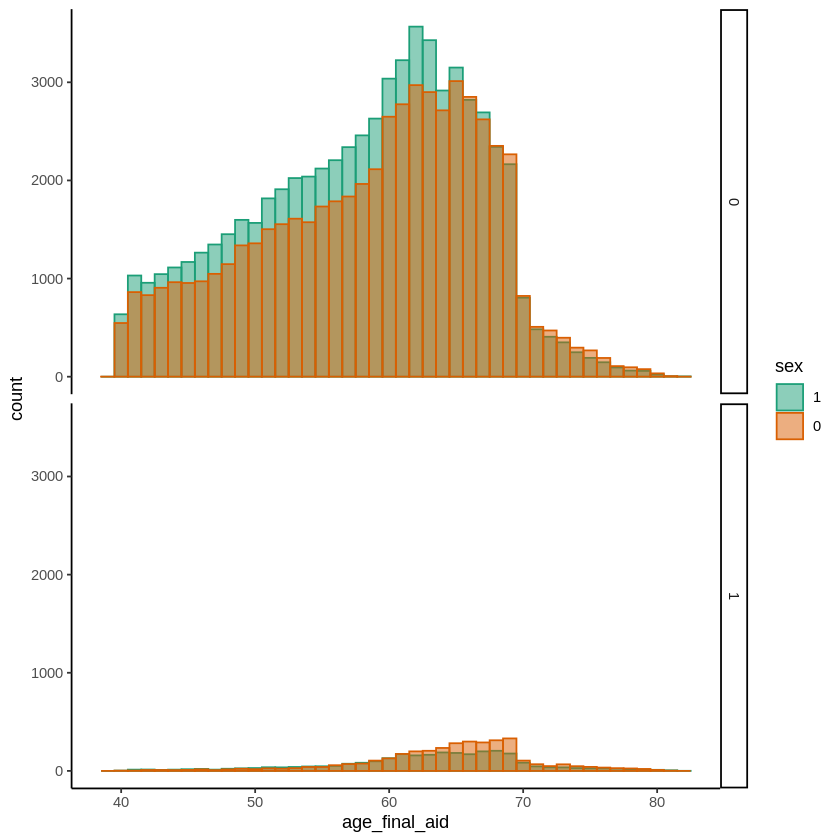

In [49]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_aid_cat ~ .)

## Find out controls positive for f.2247 & f.2257

In [50]:
control_check_3393 <- df_3393 %>%
    filter(hearing_aid_cat==0) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat, starts_with("f.2247"), starts_with("f.2257")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_3393)
dim(control_check_3393)

,FID,IID,age_final_aid,sex,hearing_aid_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,remove_2247,remove_2257
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000019,1000019,47,1,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
2,1000035,1000035,63,0,0,No,NA,NA,NA,Yes,NA,NA,NA,FALSE,TRUE
3,1000078,1000078,60,1,0,No,No,No,NA,No,No,No,NA,FALSE,FALSE
4,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,FALSE,FALSE
5,1000198,1000198,41,1,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
6,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,FALSE,FALSE


[1] 121942     15

In [51]:
length(which(control_check_3393$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_3393$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_3393$remove_2247==TRUE & control_check_3393$remove_2257==TRUE)) # controls that replied yes to both
length(which(control_check_3393$remove_2247==TRUE | control_check_3393$remove_2257==TRUE)) # controls that replied yes to either

[1] 42006

[1] 64285

[1] 34648

[1] 71643

### Export files only white-British

In [44]:
write.table(f.3393_pheno, '200828_UKBB_Hearing_aid_f3393', quote = FALSE, row.names = FALSE)

### Export files expanded white

In [44]:
write.table(f.3393_pheno, '120120_UKBB_Hearing_aid_f3393_expandedwhite', quote = FALSE, row.names = FALSE)

### Export files exome data

In [53]:
write.table(f.3393_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_aid_f3393_128254ind_exomes', quote = FALSE, row.names = FALSE)

## Hearing difficulty/problems (2247)
### step1: classify cases and controls

In [54]:
table(df.final.imp$f.2247.0.0)
dim(df.final.imp)


         Do not know I am completely deaf                   No 
                7593                   28               129917 
Prefer not to answer                  Yes 
                 120                44276 

[1] 182006   2267

In [55]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9,
                                             "I am completely deaf"=NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2247.0.0","f.2247.1.0","f.2247.2.0","f.2247.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf



f.2247.0.0_recode summary:
     9      0      1 
  7593 129917  44276 

f.2247.1.0_recode summary:
   9    0    1 
 518 6014 2893 

f.2247.2.0_recode summary:
    9     0     1 
 1276 14820  7872 

f.2247.3.0_recode summary:
  9   0   1 
 47 559 325 



## f.2247 Get possible answers

In [56]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "0019" "009"  "0090" "0091" "0099" "01"   "010"  "0100" "0101" "011" 
[21] "0111" "019"  "09"   "090"  "0900" "0901" "091"  "0910" "0911" "099" 
[31] "0991" "1"    "10"   "100"  "1000" "101"  "109"  "1090" "1099" "11"  
[41] "110"  "1101" "111"  "1111" "1119" "119"  "1190" "1191" "19"   "190" 
[51] "1900" "191"  "199"  "9"    "90"   "900"  "9000" "901"  "909"  "91"  
[61] "910"  "911"  "9111" "919"  "99"   "990"  "991"  "999"

In [57]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011   0019 
   139 109484  12724   2924     77     10      6    338      3      7      1 
   009   0090   0091   0099     01    010   0100   0101    011   0111    019 
   110      3      1      1   2700    128      3      1    383      7     29 
    09    090   0900   0901    091   0910   0911    099   0991      1     10 
   821     95      1      2     50      1      1     49      1  37565    860 
   100   1000    101    109   1090   1099     11    110   1101    111   1111 
   116      1     78      7      1      1   4298     82      1    951     26 
  1119    119   1190   1191     19    190   1900    191    199      9     90 
     1     30      1      1    238     17      1     16     14   6534    343 
   900   9000    901    909     91    910    911   9111    919     99    990 
    55      3     10     20    334      8     62      1      2    171     23 
   991    999 
    16     18 

## f.2247 Get all the consistent cases

In [58]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
109484  12724   2924     77  37565   4298    951     26   6534    171     18 

In [59]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090 0099   09  090 0900  099   90  900 9000  909  990 
   6  110    3    1  821   95    1   49  343   55    3   20   23 

In [60]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119 1191   19  191  199   91  911 9111  919  991 
   1   30    1  238   16   14  334   62    1    2   16 

In [61]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0111   10  100 1000  101  110 1101 
  10  338    3    7 2700  128    3    1  383    7  860  116    1   78   82    1 

In [62]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0019 0091  019 0901  091 0910 0911 0991  109 1090 1099 1190  190 1900  901  910 
   1    1   29    2   50    1    1    1    7    1    1    1   17    1   10    8 

In [63]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2247 Remove inconsistent cases

In [64]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","0001","001","0011","01","011","0111", "0091", "091","0911","0991","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 139 NAs, removed

In [65]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3174 inconsistent cases, removed

In [66]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_diff<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_diff)

[1] 171970      1

In [67]:
IID_hearing_diff<-IID_hearing_diff[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_diff),"cases left")

After removing all the NAs and inconsistent cases, there are 171970 cases left

In [68]:
# get the dataset after cleansing: 
df.hearing.diff<-df.final.imp %>%
  filter(IID%in%IID_hearing_diff)

dim(df.hearing.diff)

[1] 171970   2271

## f.2247 Step 1 classify cases and controls

In [69]:
hearing_diff <- df.hearing.diff %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode)
head(hearing_diff)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA


In [70]:
data_sub <- select(hearing_diff,starts_with("f.2247"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_diff$cases<-apply(data_sub, 1, f)
head(hearing_diff,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
8,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE
9,1000291,1000291,Male,62,NA,NA,NA,0,NA,NA,NA,FALSE


In [71]:
hearing_diff_cases <- hearing_diff %>% 
  filter(cases == TRUE)
head(hearing_diff_cases)
cat(dim(hearing_diff_cases)[1], "individuals are cases for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000396,1000396,Male,48,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000494,1000494,Male,61,NA,NA,NA,1,NA,NA,NA,TRUE
5,1001076,1001076,Male,69,NA,NA,NA,1,NA,NA,NA,TRUE
6,1001123,1001123,Female,62,NA,NA,NA,1,NA,NA,NA,TRUE


46761 individuals are cases for f.2247

In [72]:
hearing_diff_controls <- hearing_diff %>% 
  filter(cases == FALSE)
head(hearing_diff_controls)
cat(dim(hearing_diff_controls)[1], "individuals are controls for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
3,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
6,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


125209 individuals are controls for f.2247

In [73]:
dim(hearing_diff)[1]-246072 - 91057

[1] -165159

## f.2247 Recode cases=1 and controls=0

In [74]:
hearing_diff$hearing_diff_cat <- as.integer(as.logical(hearing_diff$cases))
head(hearing_diff, 10)
# Get the number of NAs
length(which(is.na(hearing_diff$hearing_dif_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
8,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0
9,1000291,1000291,Male,62,NA,NA,NA,0,NA,NA,NA,FALSE,0


[1] 0

## f.2247 Step 2: get the ages for hearing difficulty

In [75]:
# Get the subset data of cases
diff_age_cases = hearing_diff %>% 
  filter(hearing_diff_cat=="1")  %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_cases,12)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000198,1,NA,NA,NA,41,NA,NA,NA
3,1000396,1,NA,NA,NA,48,NA,NA,NA
4,1000494,1,NA,NA,NA,61,NA,NA,NA
5,1001076,1,NA,NA,NA,69,NA,NA,NA
6,1001123,1,NA,NA,NA,62,NA,NA,NA
7,1001316,0,NA,1,NA,45,NA,51,NA
8,1001373,1,NA,NA,NA,67,NA,NA,NA
9,1001384,1,NA,NA,NA,61,NA,NA,NA


In [76]:
# Get the # of column where first replied Yes:
diff_age_cases$visit_idx = apply(diff_age_cases, 1, function(x) unlist(which(x == '1')))
head(diff_age_cases)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2


In [77]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.22247.0.0_recode)
offset = which(colnames(diff_age_cases) == 'f.21003.0.0') - which(colnames(diff_age_cases) == 'f.2247.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
diff_age_cases$age_final_diff = apply(diff_age_cases, 1, f)

# Show first 6 rows
head(diff_age_cases)
summary(diff_age_cases$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2,69
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2,62


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   54.00   61.00   59.39   65.00   81.00 

In [78]:
### Extract age for Control (2247)
diff_age_control <- hearing_diff %>% 
  filter(hearing_diff_cat == "0") %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_control)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA
2,1000078,0,0,0,NA,52,57,60,NA
3,1000081,0,NA,NA,NA,67,NA,NA,NA
4,1000224,0,NA,NA,NA,58,NA,NA,NA
5,1000236,0,NA,0,NA,61,NA,70,NA
6,1000255,0,NA,0,NA,51,NA,61,NA


In [79]:
# Get the # of column where last replied No:
diff_age_control$visit_idx = apply(diff_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(diff_age_control) == 'f.21003.0.0') - which(colnames(diff_age_control) == 'f.2247.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
diff_age_control$age_final_diff = apply(diff_age_control, 1, f)

# Show first 6 rows
head(diff_age_control)
summary(diff_age_control$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
2,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
3,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
4,1000224,0,NA,NA,NA,58,NA,NA,NA,2,58
5,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70
6,1000255,0,NA,0,NA,51,NA,61,NA,"2, 4",61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.87   64.00   82.00 

In [80]:
# Merge age_cases and age_controls
hearing_diff_age <- rbind(diff_age_cases, diff_age_control) 
dim(hearing_diff_age)
head(hearing_diff_age)

[1] 171970     11

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2,69
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2,62


In [81]:
hearing_diff_age = merge(x = hearing_diff ,y = hearing_diff_age [,c("IID","age_final_diff")],by="IID", all.x=TRUE)
head(hearing_diff_age)
dim(hearing_diff_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat,age_final_diff
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1,41
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0,58


[1] 171970     14

## Merge dataset from f.3393 and f.2247

In [82]:
#Merge with complete database keep the all the rows from original db
df_3393_2247 = merge(x = df_3393, y = hearing_diff_age [,c("IID","hearing_diff_cat","age_final_diff")],by="IID", all.x=TRUE)
dim(df_3393_2247)
head(df_3393_2247)

[1] 182006   2271

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,exclude,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,FALSE,1,0,NA,NA,NA,0,47,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,FALSE,0,0,NA,NA,NA,0,63,0,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,FALSE,1,NA,0,0,NA,0,60,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,FALSE,0,0,NA,NA,NA,0,67,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,FALSE,1,0,NA,NA,NA,0,41,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,FALSE,0,NA,NA,NA,NA,NA,NA,NA,NA


## Reclassify individuals wearing hearing aid f.3393 but saying they don't have hearing difficulty f.2247

In [83]:
#reclassify these 85 individulas as cases for 2247
df_3393_2247$hearing_diff_cat_new <- as.factor(df_3393_2247$hearing_diff_cat)
df_3393_2247$hearing_diff_cat_new <- revalue(df_3393_2247$hearing_diff_cat_new, c('0' = "control", '1' = 'case' ))
df_3393_2247$hearing_aid_cat_new <- as.factor(df_3393_2247$hearing_aid_cat)
df_3393_2247$hearing_aid_cat_new <- revalue(df_3393_2247$hearing_aid_cat_new, c('0' = "control", '1' = 'case' ))
#hearing_diff_new <- df_3393_2247 %>% 
 # mutate(hearing_diff_cat_new =ifelse(IID%in%inconsistent_aid_diff,1,hearing_diff_cat_new))
#head(hearing_diff_new)

In [84]:
246072 + 91057 # number of controls and cases

[1] 337129

In [85]:
length(which(df_3393_2247$hearing_diff_cat_new == 'control' & df_3393_2247$hearing_aid_cat_new == 'case'))

[1] 49

In [86]:
#85 individuals state they have no hearing difficulty but they wear hearing aids
inconsistent_aid_diff <- df_3393_2247 %>%
    filter(hearing_diff_cat_new == 'control' & hearing_aid_cat_new == 'case') %>%
    select(IID)
nrow(inconsistent_aid_diff)
head(inconsistent_aid_diff)

[1] 49

,IID
,<int>
1,1200917
2,1210033
3,1362299
4,1517018
5,1541460
6,1546451


In [87]:
inconsistent_aid_diff<-unlist(inconsistent_aid_diff[,1])
cat("There are",length(inconsistent_aid_diff),"individuals that state having no hearing difficulty but wear hearing aid")

There are 49 individuals that state having no hearing difficulty but wear hearing aid

In [88]:
df_3393_2247$hearing_diff_new <- df_3393_2247$hearing_diff_cat_new
df_3393_2247$hearing_diff_new[df_3393_2247$IID %in% inconsistent_aid_diff] <- "case"

In [89]:
#91057 individuals plus 85 that wear hearing aid = 91142
check_merge <- df_3393_2247 %>% 
  select(hearing_diff_cat_new, hearing_aid_cat_new, hearing_diff_new) %>%
  filter(hearing_diff_new == "case")
head(check_merge)
nrow(check_merge)

,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new
,<fct>,<fct>,<fct>
1,case,control,case
2,case,control,case
3,case,control,case
4,case,control,case
5,case,control,case
6,case,control,case


[1] 46810

## f.2247 Verify the age for the new 85 cases

In [90]:
age_inconsistent <- df_3393_2247 %>%
    select(IID, age_final_aid, age_final_diff) %>%
    filter(IID %in% inconsistent_aid_diff)
head(age_inconsistent, 100)

,IID,age_final_aid,age_final_diff
,<int>,<int>,<int>
1,1200917,70,70
2,1210033,60,60
3,1362299,45,45
4,1517018,62,62
5,1541460,66,66
6,1546451,57,57
7,1751226,59,59
8,1817231,49,49
9,1851266,65,65


In [91]:
# There are not inconsistencies in the age of the 85 new cases therefore I can use the age_final_diff variable
all(age_inconsistent$age_final_aid == age_inconsistent$age_final_diff)

[1] TRUE

## Export file for hearing difficulty f.2247

In [92]:
df_3393_2247$hearing_diff_new <- revalue(df_3393_2247$hearing_diff_new, c('control' = "0", 'case' = '1' ))

In [93]:
f.2247_pheno <- df_3393_2247 %>%
    filter(!(is.na(hearing_diff_new))) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new)
head(f.2247_pheno)
dim(f.2247_pheno)

,FID,IID,age_final_diff,sex,hearing_diff_new
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000035,1000035,63,0,0
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,1
6,1000224,1000224,58,1,0


[1] 171970      5

## Histogram for age in f.2247

In [94]:
mu3 <- ddply(f.2247_pheno, "hearing_diff_new", summarise, grp.mean=mean(age_final_diff))
head(mu3)

,hearing_diff_new,grp.mean
,<fct>,<dbl>
1,0,56.87365
2,1,59.39028


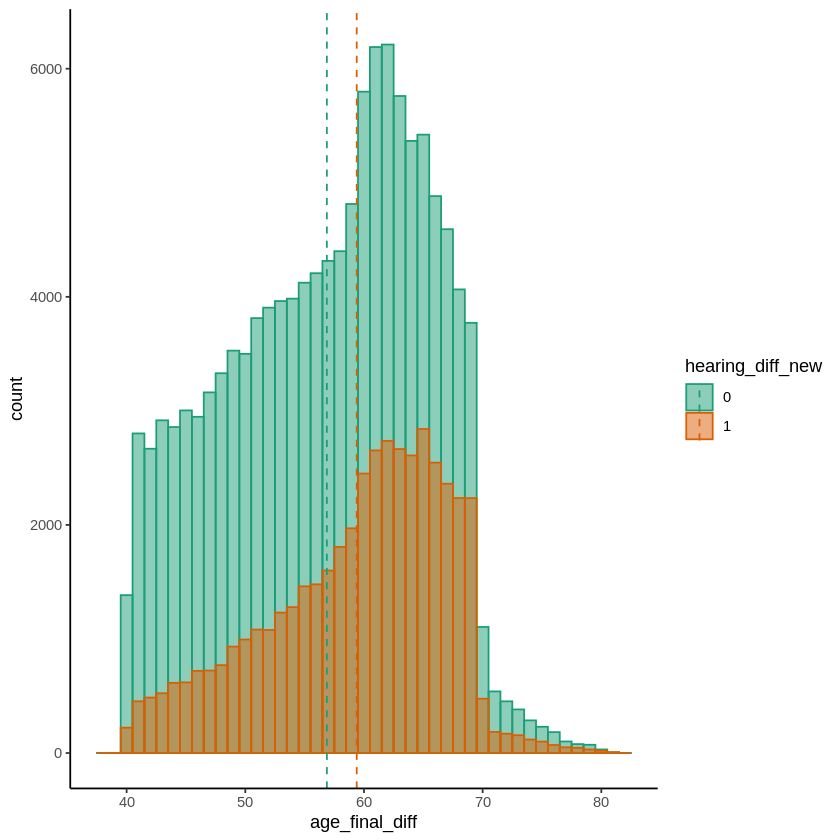

In [95]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=hearing_diff_new, color=hearing_diff_new)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu3, aes(xintercept=grp.mean, color=hearing_diff_new),
             linetype="dashed") +
  theme_classic()

In [96]:
length(which((f.2247_pheno$hearing_diff_new=="control" & f.2247_pheno$age_final_diff <50)))
length(which((f.2247_pheno$hearing_diff_new=="case" & f.2247_pheno$age_final_diff <50)))

[1] 0

[1] 0

In [97]:
mu4 <- ddply(f.2247_pheno, "sex", summarise, grp.mean=mean(age_final_diff))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,1,58.31243
2,0,59.09139


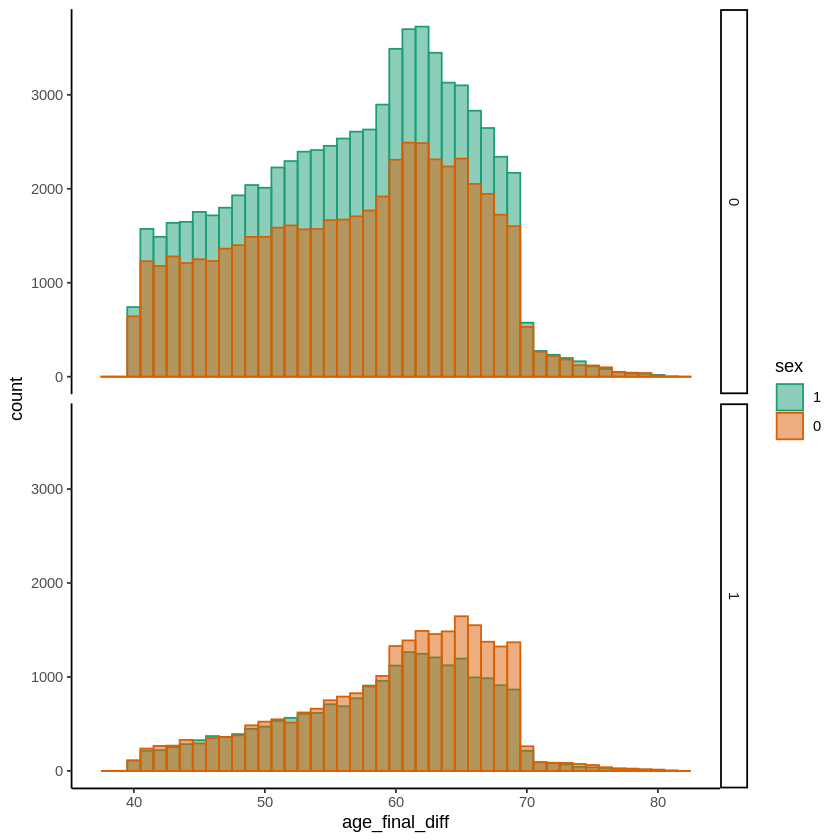

In [98]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_diff_new ~ .)

## Filter controls positive for f.3393 and/or f.2257

In [99]:
control_check_2247 <- df_3393_2247 %>%
    filter(hearing_diff_new==0) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new, starts_with("f.2257"), starts_with("f.3393")) %>%
    mutate(remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2247)

,FID,IID,age_final_diff,sex,hearing_diff_new,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2257,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000035,1000035,63,0,0,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,TRUE,FALSE
2,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
3,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
4,1000224,1000224,58,1,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
5,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE
6,1000255,1000255,61,1,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE


In [100]:
length(which(control_check_2247$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_2247$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2247$remove_2257==TRUE & control_check_2247$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2247$remove_2257==TRUE | control_check_2247$remove_3393==TRUE)) # controls that replied yes to either

[1] 25297

[1] 3

[1] 1

[1] 25299

### Export file white-British

In [93]:
write.table(f.2247_pheno, '200828_UKBB_Hearing_difficulty_f2247', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [93]:
write.table(f.2247_pheno, '120120_UKBB_Hearing_difficulty_f2247_expandedwhite', quote = FALSE, row.names = FALSE)

### Export file exome data

In [276]:
length(which(is.na(f.2247_pheno$hearing_diff_new)))

[1] 0

In [101]:
write.table(f.2247_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_difficulty_f2247_171970ind_exomes', quote = FALSE, row.names = FALSE)

## f.2257 Hearing difficulty/background noise (2257)
### step1: classify cases and controls

In [102]:
table(df.final.imp$f.2257.0.0)
dim(df.final.imp)


         Do not know                   No Prefer not to answer 
                3627               112005                  143 
                 Yes 
               66200 

[1] 182006   2271

In [103]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2257.0.0","f.2257.1.0","f.2257.2.0","f.2257.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer



f.2257.0.0_recode summary:
     9      0      1 
  3627 112005  66200 

f.2257.1.0_recode summary:
   9    0    1 
 205 5229 3993 

f.2257.2.0_recode summary:
    9     0     1 
  539 12993 10428 

f.2257.3.0_recode summary:
  9   0   1 
 25 502 404 



In [104]:
dim(df.final.imp)

[1] 182006   2275

## f.2257 Get patterns for all possible answers

In [105]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "009"  "0090" "01"   "010"  "0100" "0101" "011"  "0110" "0111" "019" 
[21] "09"   "090"  "0900" "091"  "099"  "1"    "10"   "100"  "1000" "1001"
[31] "101"  "1011" "109"  "1099" "11"   "110"  "1100" "1101" "111"  "1110"
[41] "1111" "1119" "119"  "19"   "190"  "1900" "191"  "199"  "9"    "90"  
[51] "900"  "9000" "901"  "909"  "91"   "910"  "911"  "9110" "919"  "99"  
[61] "990"  "991"  "999"  "9999"

In [106]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


          0    00   000  0000  0001  0009   001  0010  0011   009  0090    01 
  159 94611 10450  2407    62     6     2   358     6     6    42     1  3025 
  010  0100  0101   011  0110  0111   019    09   090  0900   091   099     1 
  210     2     2   385     1     7    16   338    42     2    23     5 55841 
   10   100  1000  1001   101  1011   109  1099    11   110  1100  1101   111 
 1501   233     4     1   150     3    12     1  6564   141     2     1  1528 
 1110  1111  1119   119    19   190  1900   191   199     9    90   900  9000 
    3    45     1    25   121     6     2    21     3  3119   183    26     1 
  901   909    91   910   911  9110   919    99   990   991   999  9999 
    7     3   178     9    21     1     5    53     7     7     7     2 

## f.2257 Get all the consitent cases

In [107]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


    0    00   000  0000     1    11   111  1111     9    99   999  9999 
94611 10450  2407    62 55841  6564  1528    45  3119    53     7     2 

In [108]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090   09  090 0900  099   90  900 9000  909  990 
   2   42    1  338   42    2    5  183   26    1    3    7 

In [109]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119   19  191  199   91  911  919  991 
   1   25  121   21    3  178   21    5    7 

In [110]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0110 0111   10  100 1000 1001  101 
   6  358    6    6 3025  210    2    2  385    1    7 1501  233    4    1  150 
1011  110 1100 1101 1110 
   3  141    2    1    3 

In [111]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


 019  091  109 1099  190 1900  901  910 9110 
  16   23   12    1    6    2    7    9    1 

In [112]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2257 Remove all the inconsistent

In [113]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","9991","0001","001","0011","01","011","0111", "0091", "091","0911","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 159 NAs, removed

In [114]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3135 inconsistent cases, removed

In [115]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_noise<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_noise)

[1] 175531      1

In [116]:
IID_hearing_noise<-IID_hearing_noise[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_noise),"cases left")

After removing all the NAs and inconsistent cases, there are 175531 cases left

In [117]:
# get the dataset after cleansing: 
df.hearing.noise<-df.final.imp %>%
  filter(IID%in%IID_hearing_noise)

dim(df.hearing.noise)

[1] 175531   2275

## f.2257 Step 1 classify cases and controls

In [118]:
hearing_noise <- df.hearing.noise %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode)
head(hearing_noise)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA


In [119]:
data_sub <- select(hearing_noise,starts_with("f.2257"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_noise$cases<-apply(data_sub, 1, f)
head(hearing_noise,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
8,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
9,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


In [120]:
hearing_noise_cases <- hearing_noise %>% 
  filter(cases == TRUE)
head(hearing_noise_cases)
cat(dim(hearing_noise_cases)[1], "individuals are cases for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000304,1000304,Female,56,NA,NA,NA,1,NA,NA,NA,TRUE
5,1000396,1000396,Male,48,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000494,1000494,Male,61,NA,NA,NA,1,NA,NA,NA,TRUE


68001 individuals are cases for f.2257

In [121]:
hearing_noise_controls <- hearing_noise %>% 
  filter(cases == FALSE)
head(hearing_noise_controls)
cat(dim(hearing_noise_controls)[1], "individuals are controls for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
2,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
6,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


107530 individuals are controls for f.2257

In [122]:
dim(hearing_noise)[1]-210733 - 132872

[1] -168074

## f.2257 Recode cases=1 and controls=0

In [123]:
hearing_noise$hearing_noise_cat <- as.integer(as.logical(hearing_noise$cases))
head(hearing_noise, 10)
# Get the number of NAs
length(which(is.na(hearing_noise$hearing_noise_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0
8,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
9,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0


[1] 0

## f.2257 Step 2: get the ages for hearing difficulty with background noise

In [124]:
# Get the subset data of cases
noise_age_cases = hearing_noise %>% 
  filter(hearing_noise_cat=="1")  %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_cases,12)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000035,1,NA,NA,NA,63,NA,NA,NA
3,1000198,1,NA,NA,NA,41,NA,NA,NA
4,1000304,1,NA,NA,NA,56,NA,NA,NA
5,1000396,1,NA,NA,NA,48,NA,NA,NA
6,1000494,1,NA,NA,NA,61,NA,NA,NA
7,1000551,1,NA,NA,NA,68,NA,NA,NA
8,1000817,1,NA,NA,NA,58,NA,NA,NA
9,1000875,1,NA,NA,NA,59,NA,NA,NA


In [125]:
# Get the # of column where first replied Yes:
noise_age_cases$visit_idx = apply(noise_age_cases, 1, function(x) unlist(which(x == '1')))
head(noise_age_cases)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2


In [126]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_cases) == 'f.21003.0.0') - which(colnames(noise_age_cases) == 'f.2257.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
noise_age_cases$age_final_noise = apply(noise_age_cases, 1, f)

# Show first 6 rows
head(noise_age_cases)
summary(noise_age_cases$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2,56
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   58.43   65.00   82.00 

In [127]:
### Extract age for Control (2257)
noise_age_control <- hearing_noise %>% 
  filter(hearing_noise_cat == "0") %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_control)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000078,0,0,0,NA,52,57,60,NA
2,1000081,0,NA,NA,NA,67,NA,NA,NA
3,1000210,0,NA,NA,NA,66,NA,NA,NA
4,1000224,0,NA,NA,NA,58,NA,NA,NA
5,1000236,0,NA,0,NA,61,NA,70,NA
6,1000255,0,NA,0,NA,51,NA,61,NA


In [128]:
# Get the # of column where last replied No:
noise_age_control$visit_idx = apply(noise_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_control) == 'f.21003.0.0') - which(colnames(noise_age_control) == 'f.2257.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
noise_age_control$age_final_noise = apply(noise_age_control, 1, f)

# Show first 6 rows
head(noise_age_control)
summary(noise_age_control$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
2,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
3,1000210,0,NA,NA,NA,66,NA,NA,NA,2,66
4,1000224,0,NA,NA,NA,58,NA,NA,NA,2,58
5,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70
6,1000255,0,NA,0,NA,51,NA,61,NA,"2, 4",61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.0    50.0    58.0    56.8    63.0    82.0 

In [129]:
# Merge age_cases and age_controls
hearing_noise_age <- rbind(noise_age_cases, noise_age_control) 
dim(hearing_noise_age)
head(hearing_noise_age)

[1] 175531     11

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2,56
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61


In [130]:
hearing_noise_age = merge(x = hearing_noise ,y = hearing_noise_age [,c("IID","age_final_noise")],by="IID", all.x=TRUE)
head(hearing_noise_age)
dim(hearing_noise_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat,age_final_noise
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1,63
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1,41
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE,0,66


[1] 175531     14

## Merge f.3393, f.2247 and f.2257

In [131]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257 = merge(x = df_3393_2247, y = hearing_noise_age [,c("IID","hearing_noise_cat","age_final_noise")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257)
head(df_3393_2247_2257)

[1] 182006   2276

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,0,60,0,60,control,control,0,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,0,67,0,67,control,control,0,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,0,41,1,41,case,control,1,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,66


## Export file for hearing with background noise f.2257

In [132]:
f.2257_pheno <- df_3393_2247_2257 %>%
    filter(!(is.na(hearing_noise_cat))) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat) 
    #mutate(hearing_noise_cat=recode_factor(hearing_noise_cat, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.2257_pheno)
dim(f.2257_pheno)

,FID,IID,age_final_noise,sex,hearing_noise_cat
,<int>,<int>,<int>,<fct>,<int>
1,1000019,1000019,47,1,1
2,1000035,1000035,63,0,1
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,1
6,1000210,1000210,66,0,0


[1] 175531      5

## Histogram for age of cases and controls

In [133]:
mu5 <- ddply(f.2257_pheno, "hearing_noise_cat", summarise, grp.mean=mean(age_final_noise))
head(mu)

,hearing_aid_cat,grp.mean
,<int>,<dbl>
1,0,58.41253
2,1,63.84886


In [ ]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=hearing_noise_cat, color=hearing_noise_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu5, aes(xintercept=grp.mean, color=hearing_noise_cat),
             linetype="dashed") +
  theme_classic()

In [135]:
length(which((f.2257_pheno$hearing_noise_cat=="0" & f.2257_pheno$age_final_noise <50)))

[1] 24857

In [136]:
length(which((f.2257_pheno$hearing_noise_cat=="1" & f.2257_pheno$age_final_noise <50)))

[1] 11176

In [137]:
mu6 <- ddply(f.2257_pheno, "sex", summarise, grp.mean=mean(age_final_noise))
head(mu6)

,sex,grp.mean
,<fct>,<dbl>
1,1,57.23699
2,0,57.66588


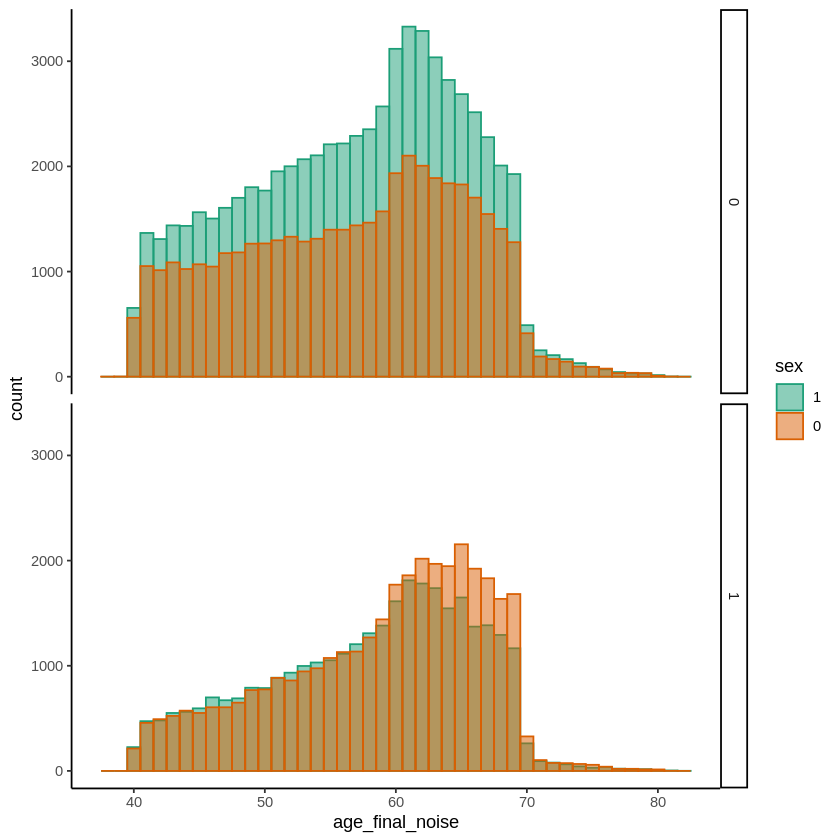

In [138]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_noise_cat ~ .)

## Find out controls positive for f.2247 & f.3393

In [139]:
control_check_2257 <- df_3393_2247_2257 %>%
    filter(hearing_noise_cat==0) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat, starts_with("f.2247"), starts_with("f.3393")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2257)

,FID,IID,age_final_noise,sex,hearing_noise_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2247,remove_3393
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
2,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
3,1000210,1000210,66,0,0,Do not know,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
4,1000224,1000224,58,1,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
5,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE
6,1000255,1000255,61,1,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE


In [140]:
length(which(control_check_2257$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_2257$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2257$remove_2247==TRUE & control_check_2257$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2257$remove_2247==TRUE | control_check_2257$remove_3393==TRUE)) # controls that replied yes to either

[1] 7022

[1] 238

[1] 209

[1] 7051

### Export files white-British

In [133]:
write.table(f.2257_pheno, '200828_UKBB_Hearing_background_noise_f2257', quote = FALSE, row.names = FALSE)

### Export files white expanded

In [133]:
write.table(f.2257_pheno, '120120_UKBB_Hearing_background_noise_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export files exome data

In [142]:
write.table(f.2257_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_background_noise_f2257_175531ind_exomes', quote = FALSE, row.names = FALSE)

## Combined phenotype f.2247 and f.2257

In [143]:
hybrid_inconsistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat != hearing_diff_new)
head(hybrid_inconsistent)
cat ("There are ",nrow(hybrid_inconsistent),"individuals inconsistent for f.2247 and f.2257")
dim(df_3393_2247_2257)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
2,1000304,1000304,0,0,2,-9,Female,1951,2008-02-15,NA,⋯,NA,0,56,0,56,control,control,0,1,56
3,1000817,1000817,0,0,1,-9,Male,1950,2009-04-18,NA,⋯,NA,0,58,0,58,control,control,0,1,58
4,1000988,1000988,0,0,2,-9,Female,1942,2008-04-10,NA,⋯,NA,0,65,0,65,control,control,0,1,65
5,1001080,1001080,0,0,2,-9,Female,1947,2010-04-30,NA,⋯,NA,0,62,0,62,control,control,0,1,62
6,1001316,1001316,0,0,1,-9,Male,1964,2010-04-08,NA,⋯,NA,0,51,1,51,case,control,1,0,51


There are  30610 individuals inconsistent for f.2247 and f.2257

[1] 182006   2276

In [144]:
length(which(!is.na(df_3393_2247_2257$hearing_noise_cat) & !is.na(df_3393_2247_2257$hearing_diff_new)))

[1] 167472

In [145]:
length(which(is.na(df_3393_2247_2257$hearing_noise_cat) | is.na(df_3393_2247_2257$hearing_diff_new))) 

[1] 14534

In [146]:
hybrid_consistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat == hearing_diff_new)
head(hybrid_consistent)
cat ("There are ",nrow(hybrid_consistent),"individuals consistent for f.2247 and f.2257")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,0,60,0,60,control,control,0,0,60
3,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,0,67,0,67,control,control,0,0,67
4,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,0,41,1,41,case,control,1,1,41
5,1000224,1000224,0,0,2,-9,Female,1951,2009-05-01,NA,⋯,NA,NA,NA,0,58,control,NA,0,0,58
6,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,0,70,0,70,control,control,0,0,70


There are  136862 individuals consistent for f.2247 and f.2257

In [147]:
age_consistency <- hybrid_consistent %>%
    select(IID, age_final_diff, age_final_noise)
head(age_consistency)

,IID,age_final_diff,age_final_noise
,<int>,<int>,<int>
1,1000019,47,47
2,1000078,60,60
3,1000081,67,67
4,1000198,41,41
5,1000224,58,58
6,1000236,70,70


In [148]:
# There are inconsistencies for the age between hearing difficulty and background noise
all(age_consistency$age_final_diff == age_consistency$age_final_noise)

[1] FALSE

In [149]:
age_inconsistency <- hybrid_consistent %>%
    filter(age_final_diff != age_final_noise)
head(age_inconsistency)
cat ("There are",nrow(age_inconsistency), "individuals with inconsistent ages for hearing difficulty and background noise")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1006407,1006407,0,0,2,-9,Female,1949,2008-09-30,NA,⋯,NA,0,65,1,59,case,control,1,1,65
2,1006513,1006513,0,0,2,-9,Female,1955,2010-02-23,NA,⋯,NA,1,59,1,59,case,case,1,1,54
3,1012730,1012730,0,0,1,-9,Male,1947,2010-05-26,NA,⋯,0,0,73,1,70,case,control,1,1,63
4,1015865,1015865,0,0,2,-9,Female,1948,2010-04-27,NA,⋯,NA,0,71,1,71,case,control,1,1,62
5,1016086,1016086,0,0,1,-9,Male,1948,2008-08-20,NA,⋯,NA,0,70,1,60,case,control,1,1,70
6,1017495,1017495,0,0,1,-9,Male,1957,2008-08-04,NA,⋯,NA,0,58,1,58,case,control,1,1,51


There are 1911 individuals with inconsistent ages for hearing difficulty and background noise

In [150]:
age_inconsistency_cases <- hybrid_consistent %>%
    filter(hearing_noise_cat == 1 &  hearing_diff_new ==1) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_cases)
cat ("There are",nrow(age_inconsistency_cases), "cases with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65
2,1006513,1006513,1,1,1,59,54
3,1012730,1012730,0,1,1,70,63
4,1015865,1015865,1,1,1,71,62
5,1016086,1016086,0,1,1,60,70
6,1017495,1017495,0,1,1,58,51


There are 1909 cases with inconsistent ages for hearing difficulty and background noise

In [151]:
age_inconsistency_controls <- hybrid_consistent %>%
    filter(hearing_noise_cat == 0 &  hearing_diff_new == 0) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_controls)
cat ("There are",nrow(age_inconsistency_controls), "controls with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1740024,1740024,0,0,0,41,46
2,5668953,5668953,1,0,0,74,69


There are 2 controls with inconsistent ages for hearing difficulty and background noise

In [152]:
#get the minimum age for 2247 and 2257 for cases
age_inconsistency_cases <- transform(age_inconsistency_cases, age_diff_noise = pmin(age_final_noise, age_final_diff))
head(age_inconsistency_cases)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65,59
2,1006513,1006513,1,1,1,59,54,54
3,1012730,1012730,0,1,1,70,63,63
4,1015865,1015865,1,1,1,71,62,62
5,1016086,1016086,0,1,1,60,70,60
6,1017495,1017495,0,1,1,58,51,51


In [153]:
#get the maximun age for 2247 and 2257 for controls
age_inconsistency_controls <- transform(age_inconsistency_controls, age_diff_noise = pmax(age_final_noise, age_final_diff))
head(age_inconsistency_controls,10)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1740024,1740024,0,0,0,41,46,46
2,5668953,5668953,1,0,0,74,69,74


In [154]:
age_solved <- rbind(age_inconsistency_cases, age_inconsistency_controls)
nrow(age_solved)
head(age_solved)

[1] 1911

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65,59
2,1006513,1006513,1,1,1,59,54,54
3,1012730,1012730,0,1,1,70,63,63
4,1015865,1015865,1,1,1,71,62,62
5,1016086,1016086,0,1,1,60,70,60
6,1017495,1017495,0,1,1,58,51,51


In [155]:
hybrid_age_consistent <- hybrid_consistent  %>%
    filter(age_final_diff == age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise) %>%
    mutate(age_diff_noise = age_final_diff) 
head(hybrid_age_consistent)
cat ("There are ",nrow(hybrid_age_consistent),"individuals consistent for age and phenotype for f.2247 and f.2257")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000078,1000078,1,0,0,60,60,60
3,1000081,1000081,0,0,0,67,67,67
4,1000198,1000198,1,1,1,41,41,41
5,1000224,1000224,1,0,0,58,58,58
6,1000236,1000236,0,0,0,70,70,70


There are  134951 individuals consistent for age and phenotype for f.2247 and f.2257

In [156]:
f2247_f2257_pheno <- rbind (hybrid_age_consistent, age_solved)
head(f2247_f2257_pheno)
nrow(f2247_f2257_pheno)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000078,1000078,1,0,0,60,60,60
3,1000081,1000081,0,0,0,67,67,67
4,1000198,1000198,1,1,1,41,41,41
5,1000224,1000224,1,0,0,58,58,58
6,1000236,1000236,0,0,0,70,70,70


[1] 136862

In [157]:
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'hearing_diff_new'] <- 'f2247_f2257'
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'age_diff_noise'] <- 'age_combined'
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
head(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000078,1000078,60,1,0
3,1000081,1000081,67,0,0
4,1000198,1000198,41,1,1
5,1000224,1000224,58,1,0
6,1000236,1000236,70,0,0


In [158]:
cases_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 1)
nrow(cases_combined)

[1] 39139

In [159]:
controls_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 0)
nrow(controls_combined)

[1] 97723

## Merge with complete database

In [160]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257_combined = merge(x = df_3393_2247_2257, y = f2247_f2257_pheno [,c("IID","f2247_f2257","age_combined")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257_combined)
head(df_3393_2247_2257_combined)

[1] 182006   2278

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise,f2247_f2257,age_combined
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,47,1,47,case,control,1,1,47,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,63,0,63,control,control,0,1,63,NA,NA
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,60,0,60,control,control,0,0,60,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,67,0,67,control,control,0,0,67,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,41,1,41,case,control,1,1,41,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,0,66,NA,NA


## Histogram for age of cases and controls

In [161]:
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
 #mutate(f2247_f2257=recode_factor(f2247_f2257, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f2247_f2257_pheno)
dim(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000078,1000078,60,1,0
3,1000081,1000081,67,0,0
4,1000198,1000198,41,1,1
5,1000224,1000224,58,1,0
6,1000236,1000236,70,0,0


[1] 136862      5

In [162]:
mu7 <- ddply(f2247_f2257_pheno, "f2247_f2257", summarise, grp.mean=mean(age_combined))
head(mu7)

,f2247_f2257,grp.mean
,<fct>,<dbl>
1,0,56.61931
2,1,59.30903


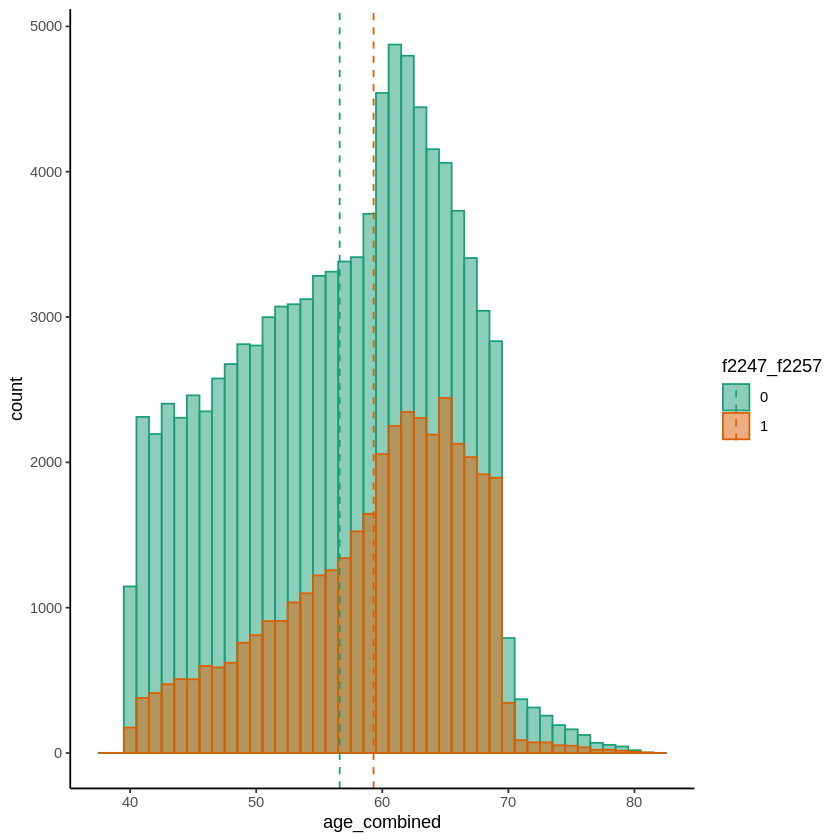

In [163]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=f2247_f2257, color=f2247_f2257)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu7, aes(xintercept=grp.mean, color=f2247_f2257),
             linetype="dashed") +
  theme_classic()

In [164]:
length(which((f2247_f2257_pheno$f2247_f2257=="0" & f2247_f2257_pheno$age_combined <50)))

[1] 23245

In [165]:
length(which((f2247_f2257_pheno$f2247_f2257=="1" & f2247_f2257_pheno$age_combined <50)))

[1] 5022

In [166]:
mu8 <- ddply(f2247_f2257_pheno, "sex", summarise, grp.mean=mean(age_combined))
head(mu8)

,sex,grp.mean
,<fct>,<dbl>
1,1,57.19423
2,0,57.63674


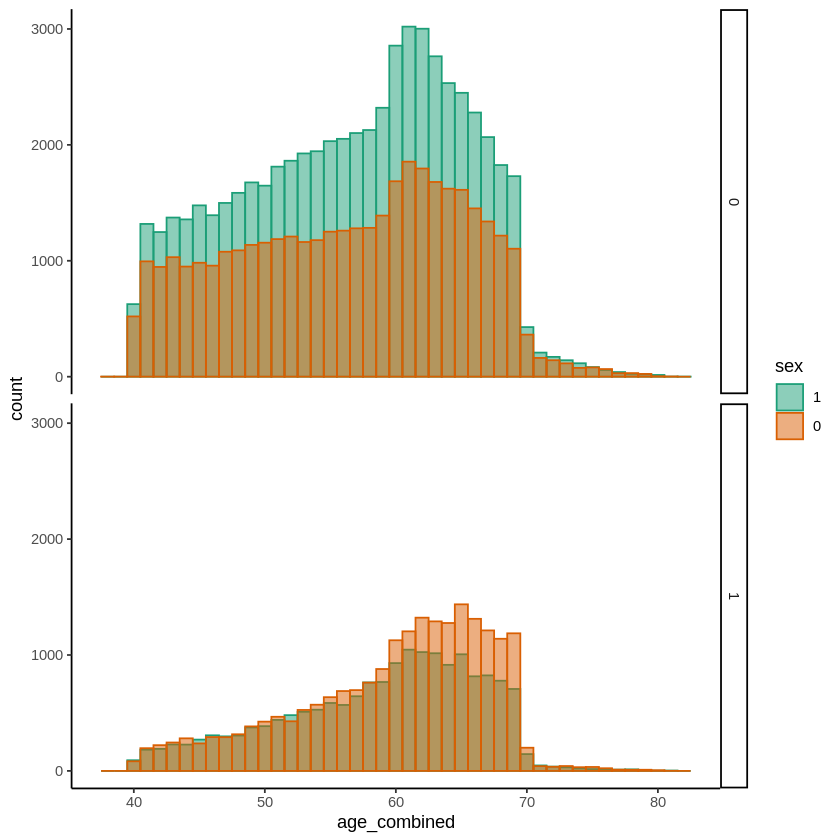

In [167]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(f2247_f2257 ~ .)

In [168]:
#Summary age of cases and controls
tapply(f2247_f2257_pheno$age_combined,  f2247_f2257_pheno$f2247_f2257, summary)

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.62   63.00   82.00 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   55.00   61.00   59.31   65.00   81.00 


## Find out controls positive for  f.3393

In [169]:
control_check_combined <- df_3393_2247_2257_combined %>%
    filter(f2247_f2257==0) %>%
    select(FID, IID, age_combined, sex, f2247_f2257, starts_with("f.3393")) %>%
    mutate(remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_combined)
dim(control_check_combined)

,FID,IID,age_combined,sex,f2247_f2257,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000078,1000078,60,1,0,NA,No,No,NA,NA,0,0,NA,FALSE
2,1000081,1000081,67,0,0,No,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000224,1000224,58,1,0,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
4,1000236,1000236,70,0,0,No,NA,No,NA,0,NA,0,NA,FALSE
5,1000255,1000255,61,1,0,No,NA,No,NA,0,NA,0,NA,FALSE
6,1000291,1000291,62,0,0,NA,NA,NA,NA,NA,NA,NA,NA,FALSE


[1] 97723    14

In [170]:
length(which(control_check_combined$remove_3393==TRUE)) #controls that replied yes to f.3393

[1] 2

### Export file white-British

In [162]:
write.table(f2247_f2257_pheno, '200828_UKBB_f2247_f2257', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [162]:
write.table(f2247_f2257_pheno, '120120_UKBB_f2247_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export exome data

In [171]:
write.table(f2247_f2257_pheno, 'phenotypes_exome_data/010421_UKBB_f2247_f2257_136862ind_exomes', quote = FALSE, row.names = FALSE)